In [7]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_transform = transforms.Compose([
    transforms.Resize((72, 72)),                    
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "data/tiny-imagenet-200"

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Классов: {len(train_dataset.class_names)}")



Train size: 100000
Val size: 10000
Классов: 200


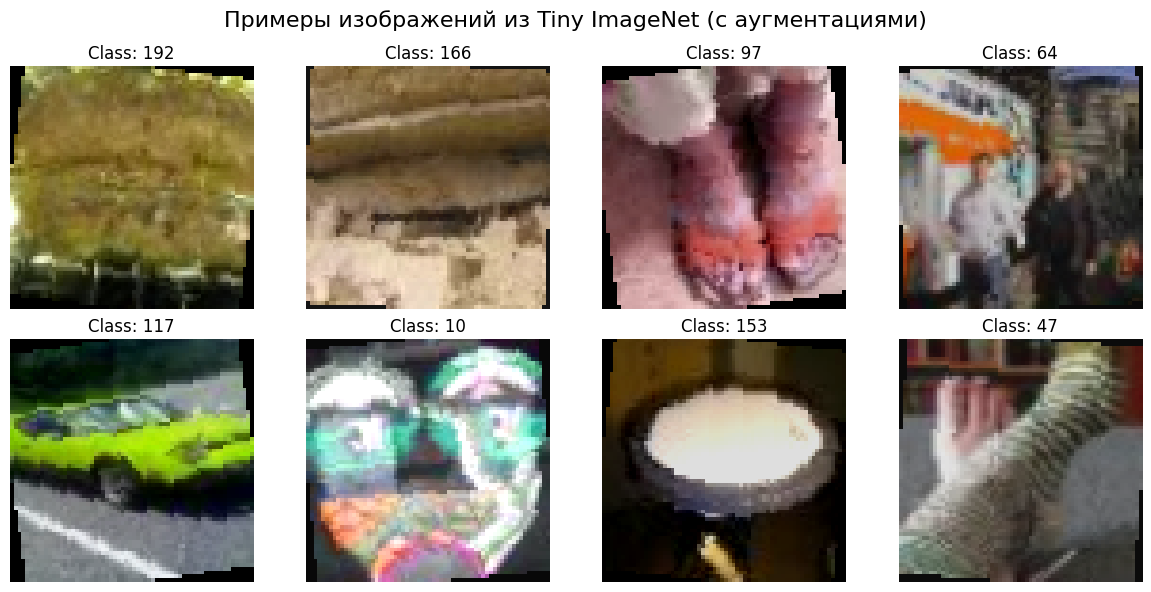

Размер батча: torch.Size([8, 3, 64, 64])
Диапазон значений: [-2.118, 2.640]
Метки классов: [192, 166, 97, 64, 117, 10, 153, 47]
Всего классов в датасете: 200
Примеры названий классов: ['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582']


In [9]:
images, labels = next(iter(train_loader))

def denormalize(img_tensor):
    """Вернём изображение из нормализованного диапазона в [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

images_vis = images.permute(0, 2, 3, 1)

images_vis = torch.stack([denormalize(img) for img in images])

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images_vis[i])
    plt.title(f"Class: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Примеры изображений из Tiny ImageNet (с аугментациями)", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Размер батча: {images.shape}")
print(f"Диапазон значений: [{images.min():.3f}, {images.max():.3f}]")
print(f"Метки классов: {labels.tolist()}")
print(f"Всего классов в датасете: {len(train_dataset.class_names)}")
print(f"Примеры названий классов: {train_dataset.class_names[:5]}")



In [10]:
selected_classes = [32, 27, 14, 17, 0, 11, 13, 3, 4, 8]  
subset_samples = [s for s in train_dataset.samples if s[1] in selected_classes]

print(f"Используем {len(subset_samples)} изображений из {len(selected_classes)} классов")
print(f"Выбранные классы: {selected_classes}")

class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

train_subset_dataset = CustomDataset(subset_samples, transform=train_transform)
subset_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=False)

print(f"Создан датасет с {len(train_subset_dataset)} образцами")


Используем 5000 изображений из 10 классов
Выбранные классы: [32, 27, 14, 17, 0, 11, 13, 3, 4, 8]
Создан датасет с 5000 образцами


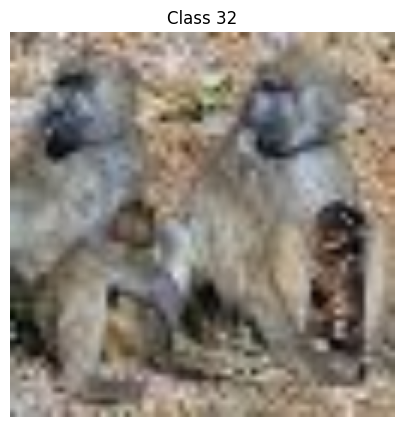

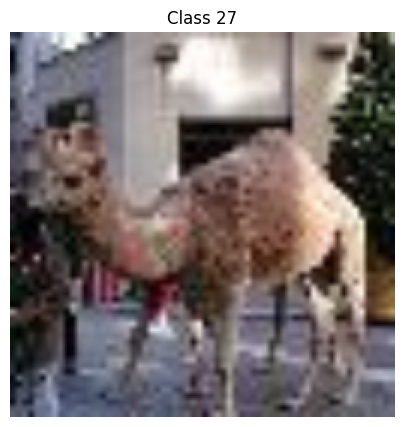

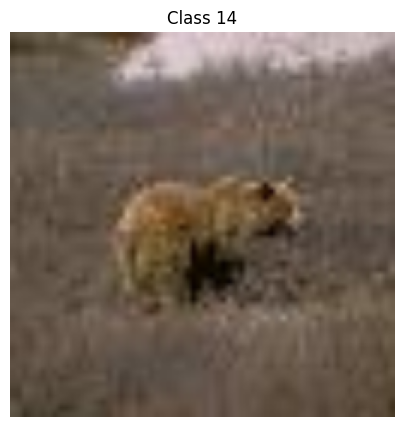

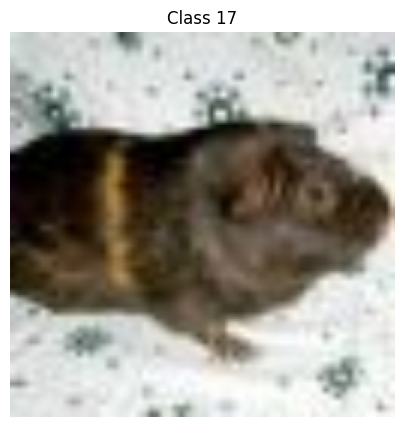

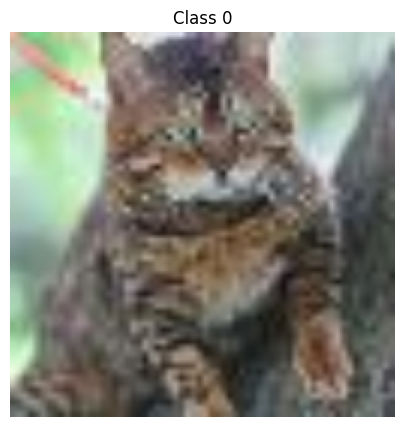

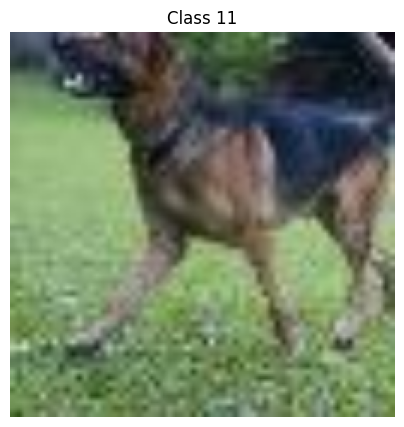

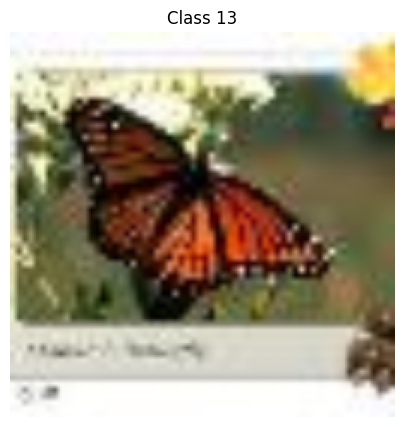

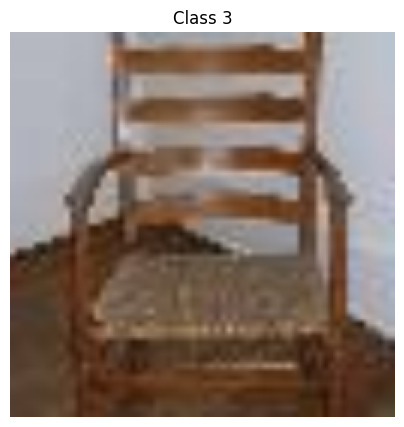

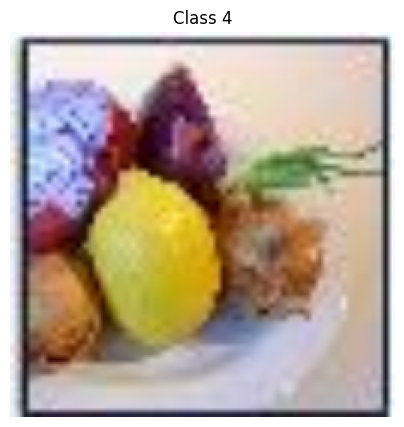

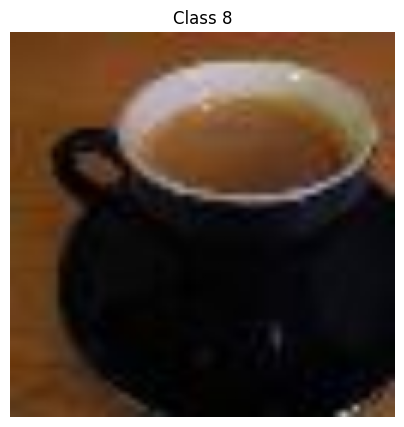

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Преобразования для изображений (если нужно)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Функция для отображения изображений из выбранных классов
def show_images_from_selected_classes(dataset, selected_classes):
    for class_idx in selected_classes:
        # Ищем первое изображение для каждого класса
        for img_path, label in dataset.samples:
            if label == class_idx:
                img = Image.open(img_path).convert('RGB')  # Загружаем изображение
                img = transform(img)  # Применяем преобразования
                plt.figure(figsize=(5, 5))  # Настроим размер картинки
                plt.imshow(img.permute(1, 2, 0))  # Отображаем изображение
                plt.title(f"Class {class_idx}")  # Заголовок с номером класса
                plt.axis('off')  # Отключаем оси
                plt.show()  # Показать изображение
                break  # Останавливаемся на первом найденном изображении для этого класса

# Выводим одно изображение из каждого выбранного класса
show_images_from_selected_classes(train_subset_dataset, selected_classes)



### Реализация Basic Block

In [12]:
# Заполните пропуски в BasicBlock
class BasicBlock(nn.Module):
    """
    Базовый блок ResNet с residual connection
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        if self.downsample is None and (in_channels != out_channels or stride != 1):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        if (self.downsample is not None):
            identity = self.downsample(x)
        else:
            identity = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        out = self.relu(x + identity)

        return out

basic_block = BasicBlock(64, 64)
test_input = torch.randn(2, 64, 32, 32)

output = basic_block(test_input)

In [13]:
class BottleneckBlock(nn.Module):
    """
    Bottleneck блок ResNet (1x1 -> 3x3 -> 1x1)
    Более эффективен для глубоких сетей
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки
        downsample (nn.Module): слой для изменения размерности
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

    def forward(self, x):
        
        return None


bottleneck_block = BottleneckBlock(64, 256)
test_input = torch.randn(2, 64, 32, 32)

output = bottleneck_block(test_input)


### Реализация ResNet18


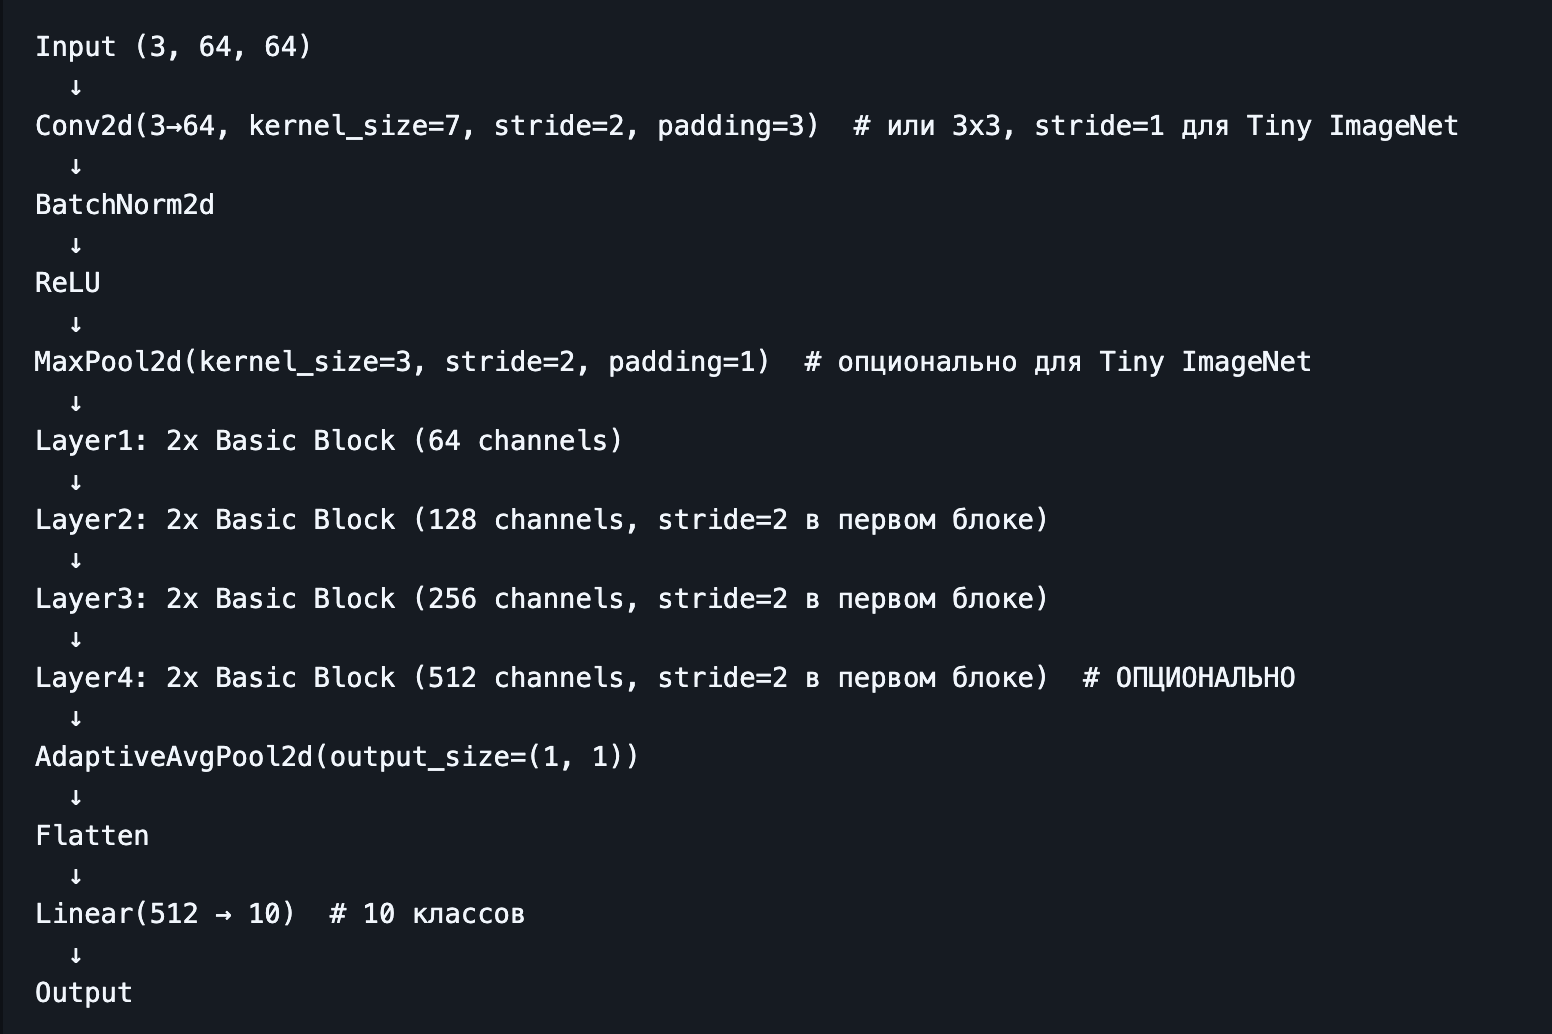

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Первый слой: свертка 3x3 с шагом 1, padding=1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Пулинг с ядром 3x3 и шагом 2

        # Слои BasicBlock
        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)  # stride=2 для уменьшения размерности
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)  # stride=2 для уменьшения размерности
        self.basic_block_3_1 = BasicBlock(256, 256)

        # self.basic_block_4_0 = BasicBlock(256, 512, stride=2)  # stride=2 для уменьшения размерности
        # self.basic_block_4_1 = BasicBlock(512, 512)

        # Финальные слои
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Адаптивный пулинг до 1x1
        self.fc = nn.Linear(256, num_classes)  # Полносвязный слой для классификации

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # Применяем первый слой
        x = self.maxpool(x)  # Применяем максимальный пулинг

        # Пропускаем через слои BasicBlock
        x = self.basic_block_1_0(x)
        x = self.basic_block_1_1(x)

        x = self.basic_block_2_0(x)
        x = self.basic_block_2_1(x)

        x = self.basic_block_3_0(x)
        x = self.basic_block_3_1(x)

        # x = self.basic_block_4_0(x)
        # x = self.basic_block_4_1(x)

        # Применяем адаптивный пулинг
        x = self.avgpool(x)

        # Преобразуем в один вектор
        x = torch.flatten(x, 1)

        # Прогоняем через полносвязный слой
        x = self.fc(x)

        return x


# Пример использования модели
model = SimpleResNet18(num_classes=10)  # 10 классов
test_input = torch.randn(1, 3, 224, 224)  # Пример входа с размерами (1, 3, 224, 224)

output = model(test_input)
print(output.shape)  # Проверим размерность вывода

# Выводим статистику о параметрах модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


torch.Size([1, 10])
Всего параметров: 2,779,850
Обучаемых параметров: 2,779,850


### Скрипт обучения

In [15]:
import torch
from tqdm import tqdm

def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Функция для одного эпоха обучения
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        train_loss: средняя потеря за эпох
        train_acc: средняя точность за эпох
    """
    model.train()  # Переводим модель в режим обучения
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc="Training")  # Прогресс-бар для обучения
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Обнуляем градиенты

        # Прямой проход (forward)
        output = model(data)

        # Вычисление потерь
        loss = criterion(output, target)

        # Обратный проход (backward)
        loss.backward()

        # Обновление параметров
        optimizer.step()

        # Подсчёт статистики
        running_loss += loss.item()

        _, predicted = output.max(1)  # Получаем предсказания (класс с максимальной вероятностью)
        total += target.size(0)  # Общее количество примеров в батче
        correct += (predicted == target).sum().item()  # Количество верных предсказаний

    train_loss = running_loss / len(train_loader)  # Среднее значение потерь
    train_acc = 100. * correct / total  # Точность обучения
    
    return train_loss, train_acc


### Функция валидации 

In [16]:
import torch
from tqdm import tqdm

def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации модели
    
    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        val_loss: средняя потеря на валидации
        val_acc: средняя точность на валидации
    """
    model.eval()  # Переводим модель в режим оценки
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc="Validation")  # Прогресс-бар для валидации
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            # Прямой проход (forward)
            output = model(data)

            # Вычисление потерь
            loss = criterion(output, target)

            # Подсчёт статистики
            running_loss += loss.item()

            _, predicted = output.max(1)  # Получаем предсказания
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss = running_loss / len(val_loader)  # Среднее значение потерь
    val_acc = 100. * correct / total  # Точность валидации
    
    return val_loss, val_acc


In [17]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=20):
    """
    Основная функция для обучения модели
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
        num_epochs: количество эпох
    
    Returns:
        history: словарь с историей обучения
    """
    print(f"Обучение на {num_epochs} эпох...")
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    model = model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f" Эпоха {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f" Сохранена лучшая модель с точностью {val_acc:.2f}%")
        
    
    return history, best_val_acc

In [18]:
# Для быстрого теста можно использовать только несколько классов


subset_train_samples = [s for s in train_dataset.samples if s[1] in selected_classes]
subset_val_samples = [s for s in val_dataset.samples if s[1] in selected_classes]

print(f"Используем {len(subset_train_samples)} train и {len(subset_val_samples)} val изображений "
      f"из {len(selected_classes)} классов")

# Перенумеровка классов
class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

subset_train_samples = remap_samples(subset_train_samples)
subset_val_samples = remap_samples(subset_val_samples)


class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_subset_dataset = CustomDataset(subset_train_samples, transform=train_transform)
val_subset_dataset = CustomDataset(subset_val_samples, transform=val_transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False)

Используем 5000 train и 500 val изображений из 10 классов


In [19]:
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    

    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

### Обучение



In [20]:
model = SimpleResNet18(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)



Обучение на 20 эпох...
 Эпоха 1/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.9579, Train Acc: 30.80%
 Val Loss: 6.8532, Val Acc: 18.40%
 Сохранена лучшая модель с точностью 18.40%
 Эпоха 2/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.7527, Train Acc: 37.92%
 Val Loss: 8.9850, Val Acc: 16.00%
 Эпоха 3/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.6262, Train Acc: 43.66%
 Val Loss: 3.2754, Val Acc: 29.00%
 Сохранена лучшая модель с точностью 29.00%
 Эпоха 4/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.5346, Train Acc: 46.34%
 Val Loss: 2.0130, Val Acc: 37.80%
 Сохранена лучшая модель с точностью 37.80%
 Эпоха 5/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.3963, Train Acc: 51.58%
 Val Loss: 2.9361, Val Acc: 35.40%
 Эпоха 6/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.2865, Train Acc: 56.46%
 Val Loss: 2.5531, Val Acc: 37.20%
 Эпоха 7/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.2482, Train Acc: 57.46%
 Val Loss: 5.3451, Val Acc: 21.80%
 Эпоха 8/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1723, Train Acc: 60.06%
 Val Loss: 4.5837, Val Acc: 29.80%
 Эпоха 9/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1578, Train Acc: 61.22%
 Val Loss: 2.4098, Val Acc: 37.00%
 Эпоха 10/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.0538, Train Acc: 64.42%
 Val Loss: 1.5665, Val Acc: 52.00%
 Сохранена лучшая модель с точностью 52.00%
 Эпоха 11/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.9965, Train Acc: 66.40%
 Val Loss: 3.3821, Val Acc: 30.80%
 Эпоха 12/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.9663, Train Acc: 67.18%
 Val Loss: 3.8012, Val Acc: 34.20%
 Эпоха 13/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.9504, Train Acc: 67.30%
 Val Loss: 1.8823, Val Acc: 46.80%
 Эпоха 14/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.8967, Train Acc: 69.80%
 Val Loss: 1.5042, Val Acc: 55.60%
 Сохранена лучшая модель с точностью 55.60%
 Эпоха 15/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.8620, Train Acc: 70.46%
 Val Loss: 1.3656, Val Acc: 59.80%
 Сохранена лучшая модель с точностью 59.80%
 Эпоха 16/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.8612, Train Acc: 70.54%
 Val Loss: 1.3006, Val Acc: 56.40%
 Эпоха 17/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.8060, Train Acc: 71.70%
 Val Loss: 1.7395, Val Acc: 51.60%
 Эпоха 18/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.7964, Train Acc: 73.08%
 Val Loss: 1.2542, Val Acc: 59.80%
 Эпоха 19/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.7696, Train Acc: 74.10%
 Val Loss: 2.4844, Val Acc: 42.60%
 Эпоха 20/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]

 Train Loss: 0.7658, Train Acc: 74.44%
 Val Loss: 1.6410, Val Acc: 56.20%


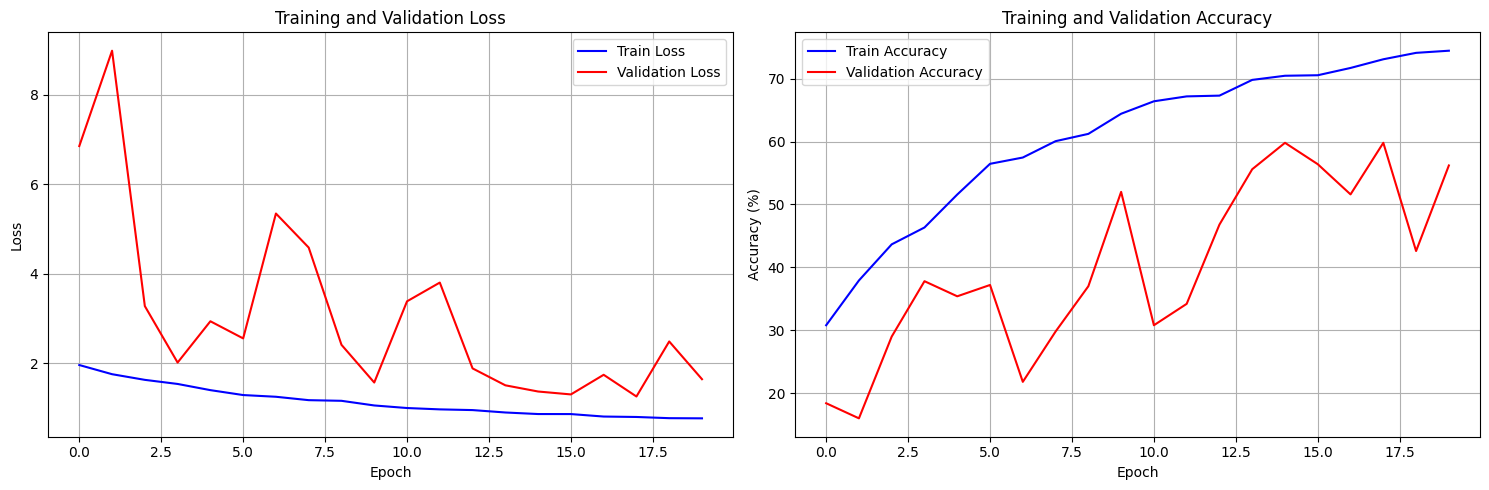

In [21]:
plot_training_history(history)

In [22]:
print(best_acc_val)

59.8


- Всего параметров: 2,779,850
- loss постепенну уменьшается, что говорит о хорошем процесее обучения, однако на валидации видны скачки, что может говорить о переобучении или нестабильности модели
- Точность - растет на трейне, но на валидации видны колебания, что также может говорить о переобучнии 

In [23]:
print(model)

SimpleResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (basic_block_1_0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (basic_block_1_1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

## Поэтапная оптимизация модели

### 3.1: Оптимизация количества каналов

#### Вариант A: 32 → 64 → 128 → 256 каналов

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNet_3A(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Первый слой: свертка 3x3 с шагом 1, padding=1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Пулинг с ядром 3x3 и шагом 2

        # Слои BasicBlock
        self.basic_block_1_0 = BasicBlock(32, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)  # stride=2 для уменьшения размерности
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)  # stride=2 для уменьшения размерности
        self.basic_block_3_1 = BasicBlock(256, 256)

        # self.basic_block_4_0 = BasicBlock(256, 512, stride=2)  # stride=2 для уменьшения размерности
        # self.basic_block_4_1 = BasicBlock(512, 512)

        # Финальные слои
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Адаптивный пулинг до 1x1
        self.fc = nn.Linear(256, num_classes)  # Полносвязный слой для классификации

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # Применяем первый слой
        x = self.maxpool(x)  # Применяем максимальный пулинг

        # Пропускаем через слои BasicBlock
        x = self.basic_block_1_0(x)
        x = self.basic_block_1_1(x)

        x = self.basic_block_2_0(x)
        x = self.basic_block_2_1(x)

        x = self.basic_block_3_0(x)
        x = self.basic_block_3_1(x)

        # x = self.basic_block_4_0(x)
        # x = self.basic_block_4_1(x)

        # Применяем адаптивный пулинг
        x = self.avgpool(x)

        # Преобразуем в один вектор
        x = torch.flatten(x, 1)

        # Прогоняем через полносвязный слой
        x = self.fc(x)

        return x


# Пример использования модели
model = SimpleResNet_3A(num_classes=10)  # 10 классов
test_input = torch.randn(1, 3, 224, 224)  # Пример входа с размерами (1, 3, 224, 224)

output = model(test_input)
print(output.shape)  # Проверим размерность вывода

# Выводим статистику о параметрах модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


torch.Size([1, 10])
Всего параметров: 2,762,730
Обучаемых параметров: 2,762,730


In [25]:
model = SimpleResNet_3A(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)



Обучение на 20 эпох...
 Эпоха 1/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.9414, Train Acc: 29.76%
 Val Loss: 2.4181, Val Acc: 27.20%
 Сохранена лучшая модель с точностью 27.20%
 Эпоха 2/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.7117, Train Acc: 38.20%
 Val Loss: 2.9856, Val Acc: 22.80%
 Эпоха 3/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.5964, Train Acc: 44.20%
 Val Loss: 2.0383, Val Acc: 38.80%
 Сохранена лучшая модель с точностью 38.80%
 Эпоха 4/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.4587, Train Acc: 48.80%
 Val Loss: 2.7331, Val Acc: 31.00%
 Эпоха 5/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.3632, Train Acc: 52.76%
 Val Loss: 2.1231, Val Acc: 37.20%
 Эпоха 6/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.2598, Train Acc: 56.90%
 Val Loss: 2.4014, Val Acc: 38.00%
 Эпоха 7/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.1907, Train Acc: 59.70%
 Val Loss: 1.5603, Val Acc: 48.80%
 Сохранена лучшая модель с точностью 48.80%
 Эпоха 8/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.1118, Train Acc: 62.10%
 Val Loss: 2.0176, Val Acc: 40.60%
 Эпоха 9/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.1256, Train Acc: 61.94%
 Val Loss: 1.7578, Val Acc: 49.60%
 Сохранена лучшая модель с точностью 49.60%
 Эпоха 10/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.0489, Train Acc: 64.26%
 Val Loss: 2.1349, Val Acc: 44.40%
 Эпоха 11/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.0111, Train Acc: 65.58%
 Val Loss: 1.5410, Val Acc: 52.80%
 Сохранена лучшая модель с точностью 52.80%
 Эпоха 12/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.9609, Train Acc: 66.70%
 Val Loss: 1.4376, Val Acc: 52.40%
 Эпоха 13/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.9721, Train Acc: 67.24%
 Val Loss: 1.4818, Val Acc: 52.60%
 Эпоха 14/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.9164, Train Acc: 69.06%
 Val Loss: 1.7056, Val Acc: 49.60%
 Эпоха 15/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.8598, Train Acc: 70.42%
 Val Loss: 1.2741, Val Acc: 58.40%
 Сохранена лучшая модель с точностью 58.40%
 Эпоха 16/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.8351, Train Acc: 71.88%
 Val Loss: 1.4600, Val Acc: 53.60%
 Эпоха 17/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.7992, Train Acc: 72.90%
 Val Loss: 2.2451, Val Acc: 42.60%
 Эпоха 18/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.7934, Train Acc: 72.28%
 Val Loss: 1.2825, Val Acc: 59.20%
 Сохранена лучшая модель с точностью 59.20%
 Эпоха 19/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.7572, Train Acc: 74.54%
 Val Loss: 1.3770, Val Acc: 59.00%
 Эпоха 20/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]

 Train Loss: 0.7332, Train Acc: 74.64%
 Val Loss: 1.5067, Val Acc: 55.60%


In [33]:
print(best_acc_val)

59.2


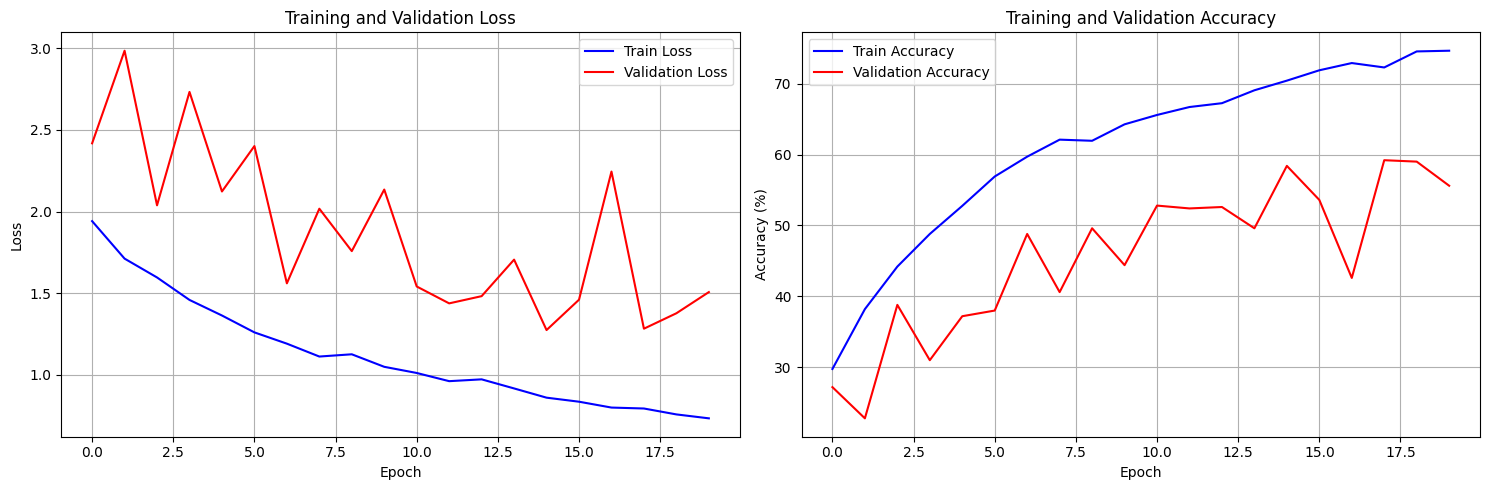

In [34]:
plot_training_history(history)

#### Вариант B: 64 → 128 → 256 каналов (без 4-го слоя) 

Данная модель была базовой 

**Вывод**
Модели показали схожие результаты, но точность чуть больше у варианта B

### 3.2: Эксперименты с количеством residual блоков


#### Вариант A (4 блока):  Layer1[1 блок] → Layer2[1 блок] → Layer3[1 блок] → Layer4[1 блок]


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNet_32A(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Первый слой: свертка 3x3 с шагом 1, padding=1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Пулинг с ядром 3x3 и шагом 2

        # Слои BasicBlock
        self.basic_block_1_0 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)  

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)  

        # Финальные слои
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc = nn.Linear(256, num_classes)  

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  
        x = self.maxpool(x)  

        # Пропускаем через слои BasicBlock
        x = self.basic_block_1_0(x)

        x = self.basic_block_2_0(x)

        x = self.basic_block_3_0(x)

        # Применяем адаптивный пулинг
        x = self.avgpool(x)

        # Преобразуем в один вектор
        x = torch.flatten(x, 1)

        # Прогоняем через полносвязный слой
        x = self.fc(x)

        return x


# Пример использования модели
model = SimpleResNet_32A(num_classes=10)  # 10 классов
test_input = torch.randn(1, 3, 224, 224)  # Пример входа с размерами (1, 3, 224, 224)

output = model(test_input)
print(output.shape)  # Проверим размерность вывода

# Выводим статистику о параметрах модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


torch.Size([1, 10])
Всего параметров: 1,228,874
Обучаемых параметров: 1,228,874


In [43]:
model = SimpleResNet_32A(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)



Обучение на 20 эпох...
 Эпоха 1/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.9187, Train Acc: 30.40%
 Val Loss: 2.8590, Val Acc: 24.20%
 Сохранена лучшая модель с точностью 24.20%
 Эпоха 2/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.6997, Train Acc: 40.32%
 Val Loss: 2.0587, Val Acc: 33.80%
 Сохранена лучшая модель с точностью 33.80%
 Эпоха 3/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.5642, Train Acc: 46.58%
 Val Loss: 4.3384, Val Acc: 29.00%
 Эпоха 4/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.4453, Train Acc: 50.38%
 Val Loss: 6.4111, Val Acc: 20.00%
 Эпоха 5/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.3409, Train Acc: 53.72%
 Val Loss: 1.6544, Val Acc: 45.40%
 Сохранена лучшая модель с точностью 45.40%
 Эпоха 6/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.2350, Train Acc: 58.00%
 Val Loss: 1.9590, Val Acc: 40.60%
 Эпоха 7/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1696, Train Acc: 60.16%
 Val Loss: 3.3960, Val Acc: 35.00%
 Эпоха 8/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1292, Train Acc: 61.72%
 Val Loss: 1.6252, Val Acc: 48.60%
 Сохранена лучшая модель с точностью 48.60%
 Эпоха 9/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.0691, Train Acc: 64.14%
 Val Loss: 4.4958, Val Acc: 31.40%
 Эпоха 10/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.0534, Train Acc: 64.22%
 Val Loss: 1.7299, Val Acc: 48.60%
 Эпоха 11/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.0134, Train Acc: 66.68%
 Val Loss: 1.8450, Val Acc: 46.80%
 Эпоха 12/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9521, Train Acc: 68.82%
 Val Loss: 2.5920, Val Acc: 38.60%
 Эпоха 13/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9184, Train Acc: 69.12%
 Val Loss: 2.2876, Val Acc: 41.80%
 Эпоха 14/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9171, Train Acc: 69.18%
 Val Loss: 1.4705, Val Acc: 55.60%
 Сохранена лучшая модель с точностью 55.60%
 Эпоха 15/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8755, Train Acc: 70.62%
 Val Loss: 1.6296, Val Acc: 53.20%
 Эпоха 16/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8441, Train Acc: 71.08%
 Val Loss: 1.8269, Val Acc: 51.60%
 Эпоха 17/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8290, Train Acc: 71.72%
 Val Loss: 2.2622, Val Acc: 45.40%
 Эпоха 18/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8045, Train Acc: 73.20%
 Val Loss: 1.5325, Val Acc: 54.60%
 Эпоха 19/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.7819, Train Acc: 73.90%
 Val Loss: 1.9445, Val Acc: 49.20%
 Эпоха 20/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]

 Train Loss: 0.7620, Train Acc: 74.60%
 Val Loss: 2.1962, Val Acc: 45.20%


In [44]:
print(best_acc_val)

55.6


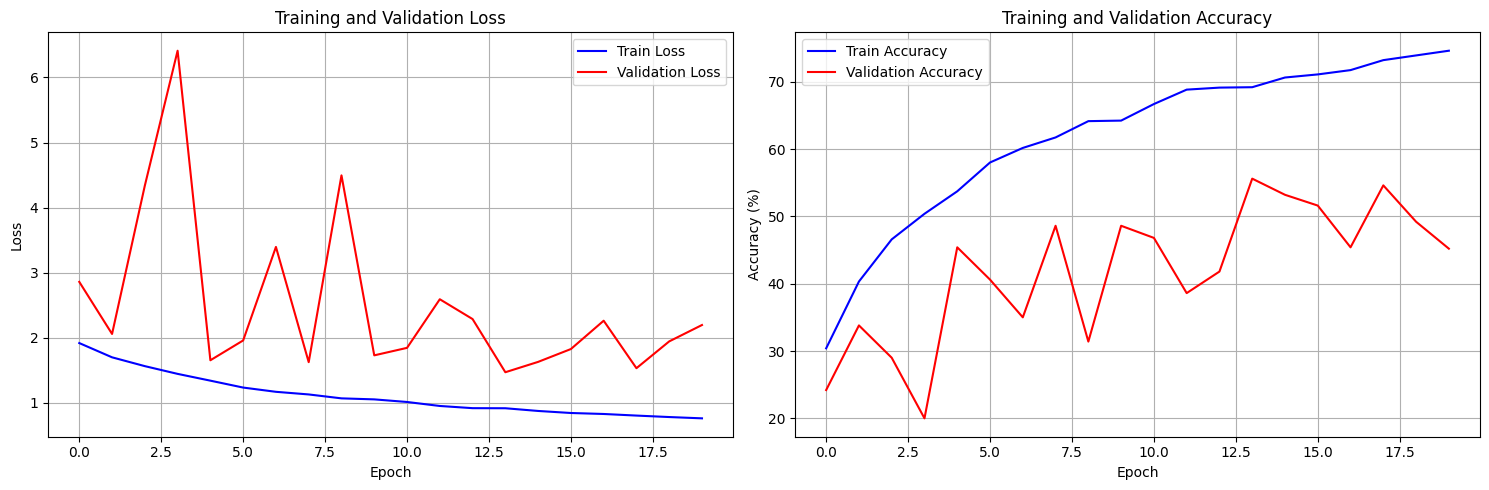

In [45]:
plot_training_history(history)

#### Вариант B (8 блоков): Layer1[2 блока] → Layer2[2 блока] → Layer3[2 блока] → Layer4[2 блока]


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNet_32B(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Первый слой: свертка 3x3 с шагом 1, padding=1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Пулинг с ядром 3x3 и шагом 2

        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)  # stride=2 для уменьшения размерности
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)  # stride=2 для уменьшения размерности
        self.basic_block_3_1 = BasicBlock(256, 256)

        # Финальные слои
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc = nn.Linear(256, num_classes)  

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  
        x = self.maxpool(x)  

        # Пропускаем через слои BasicBlock
        x = self.basic_block_1_0(x)
        x = self.basic_block_1_1(x)

        x = self.basic_block_2_0(x)
        x = self.basic_block_2_1(x)

        x = self.basic_block_3_0(x)
        x = self.basic_block_3_1(x)

        # Применяем адаптивный пулинг
        x = self.avgpool(x)

        # Преобразуем в один вектор
        x = torch.flatten(x, 1)

        # Прогоняем через полносвязный слой
        x = self.fc(x)

        return x


# Пример использования модели
model = SimpleResNet_32B(num_classes=10)  # 10 классов
test_input = torch.randn(1, 3, 224, 224)  # Пример входа с размерами (1, 3, 224, 224)

output = model(test_input)
print(output.shape)  # Проверим размерность вывода

# Выводим статистику о параметрах модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


torch.Size([1, 10])
Всего параметров: 2,779,850
Обучаемых параметров: 2,779,850


In [46]:
model = SimpleResNet_32B(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)



Обучение на 20 эпох...
 Эпоха 1/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.9505, Train Acc: 29.56%
 Val Loss: 2.5533, Val Acc: 29.00%
 Сохранена лучшая модель с точностью 29.00%
 Эпоха 2/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.7953, Train Acc: 35.46%
 Val Loss: 3.4794, Val Acc: 26.00%
 Эпоха 3/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.6914, Train Acc: 40.22%
 Val Loss: 3.4402, Val Acc: 26.20%
 Эпоха 4/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.5571, Train Acc: 45.92%
 Val Loss: 2.2818, Val Acc: 34.40%
 Сохранена лучшая модель с точностью 34.40%
 Эпоха 5/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.4594, Train Acc: 49.94%
 Val Loss: 6.3950, Val Acc: 18.40%
 Эпоха 6/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.4050, Train Acc: 51.50%
 Val Loss: 3.3783, Val Acc: 28.20%
 Эпоха 7/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.2823, Train Acc: 55.92%
 Val Loss: 1.9153, Val Acc: 42.40%
 Сохранена лучшая модель с точностью 42.40%
 Эпоха 8/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.2530, Train Acc: 57.86%
 Val Loss: 2.7173, Val Acc: 36.20%
 Эпоха 9/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.1408, Train Acc: 60.80%
 Val Loss: 3.8334, Val Acc: 33.80%
 Эпоха 10/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.0962, Train Acc: 62.94%
 Val Loss: 2.4165, Val Acc: 41.40%
 Эпоха 11/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.0528, Train Acc: 64.20%
 Val Loss: 2.8732, Val Acc: 39.00%
 Эпоха 12/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 1.0101, Train Acc: 66.36%
 Val Loss: 2.6595, Val Acc: 37.80%
 Эпоха 13/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.9509, Train Acc: 67.54%
 Val Loss: 2.5056, Val Acc: 40.80%
 Эпоха 14/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.9214, Train Acc: 69.28%
 Val Loss: 2.1926, Val Acc: 41.80%
 Эпоха 15/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.9041, Train Acc: 69.48%
 Val Loss: 2.1700, Val Acc: 44.20%
 Сохранена лучшая модель с точностью 44.20%
 Эпоха 16/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.8831, Train Acc: 69.60%
 Val Loss: 1.5689, Val Acc: 54.80%
 Сохранена лучшая модель с точностью 54.80%
 Эпоха 17/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.8315, Train Acc: 71.08%
 Val Loss: 2.2399, Val Acc: 45.20%
 Эпоха 18/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.8260, Train Acc: 72.00%
 Val Loss: 1.7601, Val Acc: 52.20%
 Эпоха 19/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]


 Train Loss: 0.7813, Train Acc: 73.04%
 Val Loss: 2.5212, Val Acc: 44.00%
 Эпоха 20/20


Validation:   0%|          | 0/8 [00:02<?, ?it/s]

 Train Loss: 0.7498, Train Acc: 74.72%
 Val Loss: 1.9217, Val Acc: 50.00%


In [47]:
print(best_acc_val)

54.8


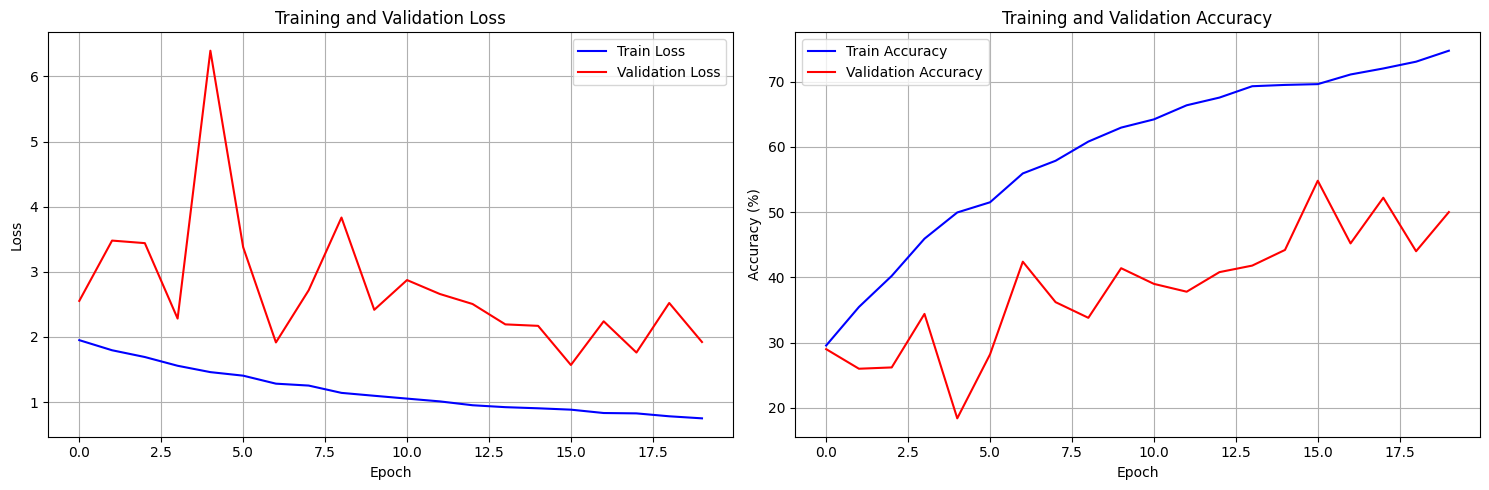

In [48]:
plot_training_history(history)

#### Вариант C (12 блоков): Layer1[3 блока] → Layer2[3 блока] → Layer3[3 блока] → Layer4[3 блока]


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNet_32C(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Первый слой: свертка 3x3 с шагом 1, padding=1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Пулинг с ядром 3x3 и шагом 2

        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)
        self.basic_block_1_2 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)  # stride=2 для уменьшения размерности
        self.basic_block_2_1 = BasicBlock(128, 128)
        self.basic_block_2_2 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)  # stride=2 для уменьшения размерности
        self.basic_block_3_1 = BasicBlock(256, 256)
        self.basic_block_3_2 = BasicBlock(256, 256)

        # Финальные слои
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc = nn.Linear(256, num_classes)  

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  
        x = self.maxpool(x)  

        # Пропускаем через слои BasicBlock
        x = self.basic_block_1_0(x)
        x = self.basic_block_1_1(x)
        x = self.basic_block_1_2(x)

        x = self.basic_block_2_0(x)
        x = self.basic_block_2_1(x)
        x = self.basic_block_2_2(x)

        x = self.basic_block_3_0(x)
        x = self.basic_block_3_1(x)
        x = self.basic_block_3_2(x)

        # Применяем адаптивный пулинг
        x = self.avgpool(x)

        # Преобразуем в один вектор
        x = torch.flatten(x, 1)

        # Прогоняем через полносвязный слой
        x = self.fc(x)

        return x


# Пример использования модели
model = SimpleResNet_32C(num_classes=10)  # 10 классов
test_input = torch.randn(1, 3, 224, 224)  # Пример входа с размерами (1, 3, 224, 224)

output = model(test_input)
print(output.shape)  # Проверим размерность вывода

# Выводим статистику о параметрах модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


torch.Size([1, 10])
Всего параметров: 4,330,826
Обучаемых параметров: 4,330,826


In [49]:
model = SimpleResNet_32C(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)



Обучение на 20 эпох...
 Эпоха 1/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 2.0148, Train Acc: 27.12%
 Val Loss: 5.3382, Val Acc: 17.80%
 Сохранена лучшая модель с точностью 17.80%
 Эпоха 2/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.8288, Train Acc: 33.62%
 Val Loss: 3.2498, Val Acc: 22.00%
 Сохранена лучшая модель с точностью 22.00%
 Эпоха 3/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.7178, Train Acc: 38.88%
 Val Loss: 2.2480, Val Acc: 35.00%
 Сохранена лучшая модель с точностью 35.00%
 Эпоха 4/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.6495, Train Acc: 41.52%
 Val Loss: 2.6084, Val Acc: 24.60%
 Эпоха 5/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.5521, Train Acc: 46.74%
 Val Loss: 4.4846, Val Acc: 22.40%
 Эпоха 6/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.4620, Train Acc: 49.74%
 Val Loss: 2.6485, Val Acc: 34.00%
 Эпоха 7/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.3900, Train Acc: 51.78%
 Val Loss: 2.1061, Val Acc: 36.20%
 Сохранена лучшая модель с точностью 36.20%
 Эпоха 8/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.3300, Train Acc: 54.02%
 Val Loss: 3.3603, Val Acc: 27.40%
 Эпоха 9/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.2519, Train Acc: 56.90%
 Val Loss: 1.6631, Val Acc: 46.80%
 Сохранена лучшая модель с точностью 46.80%
 Эпоха 10/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.1833, Train Acc: 59.36%
 Val Loss: 2.0605, Val Acc: 45.20%
 Эпоха 11/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.1350, Train Acc: 60.44%
 Val Loss: 3.9413, Val Acc: 29.60%
 Эпоха 12/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.1009, Train Acc: 62.18%
 Val Loss: 2.4458, Val Acc: 39.20%
 Эпоха 13/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.0544, Train Acc: 63.66%
 Val Loss: 1.9632, Val Acc: 42.60%
 Эпоха 14/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 1.0147, Train Acc: 66.44%
 Val Loss: 3.1131, Val Acc: 33.20%
 Эпоха 15/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 0.9811, Train Acc: 66.74%
 Val Loss: 2.9063, Val Acc: 35.80%
 Эпоха 16/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 0.9419, Train Acc: 68.32%
 Val Loss: 1.3459, Val Acc: 57.80%
 Сохранена лучшая модель с точностью 57.80%
 Эпоха 17/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 0.9495, Train Acc: 67.92%
 Val Loss: 1.7448, Val Acc: 48.40%
 Эпоха 18/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 0.8799, Train Acc: 70.18%
 Val Loss: 1.5090, Val Acc: 55.00%
 Эпоха 19/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]


 Train Loss: 0.8590, Train Acc: 70.30%
 Val Loss: 2.2664, Val Acc: 44.20%
 Эпоха 20/20


Validation:   0%|          | 0/8 [00:03<?, ?it/s]

 Train Loss: 0.8530, Train Acc: 71.20%
 Val Loss: 1.2365, Val Acc: 62.20%
 Сохранена лучшая модель с точностью 62.20%


In [50]:
print(best_acc_val)

62.2


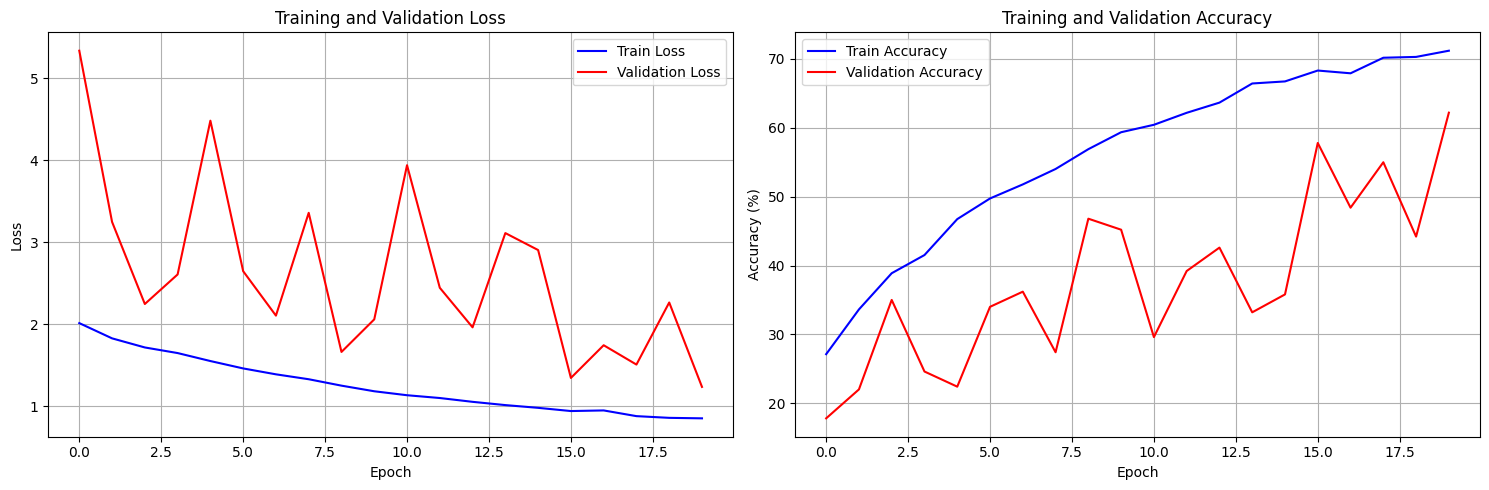

In [51]:
plot_training_history(history)

Количество параметров
Validation accuracy
Скорость сходимости (на каких эпохах модель достигает лучших результатов)
Графики accuracy для всех трех вариантов на одном графике
Анализ: какая глубина оптимальна? Есть ли переобучение у более глубоких моделей?
Вывод: какое количество блоков работает лучше?

In [56]:
results = [
    {"Модель": "ResNet18Small", "Количество параметров": '1,228,874', "Точность": '55.6', "Скорость сходимости": '16'},
    {"Модель": "ResNet18Normal", "Количество параметров": '2,779,850' , "Точность": '54.8', "Скорость сходимости": '15'},
    {"Модель": "ResNet18Large", "Количество параметров": '4,330,826', "Точность": '62.2', "Скорость сходимости": '20'},
]

df = pd.DataFrame(results)
df

,Модель,Количество параметров,Точность,Скорость сходимости
0,ResNet18Small,"1,228,874",55.6,16
1,ResNet18Normal,"2,779,850",54.8,15
2,ResNet18Large,"4,330,826",62.2,20


Large модель показала лучший результат по точности за сходимость в 20 эпох, что может указывать, что у более глубоких моделей не наблюдается переобучения, хотя Normal модель отработала хуже, чем Small

**Однако** из-за слишком долгого процесса обучения Large модель дальше не будет использоваться, вместо нее возьму Small, которая оказалась 2ой по точности

### 3.3: Эксперименты с функциями активации

Вариант A: ReLU (baseline)

Вариант B: LeakyReLU

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNet_33B(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Первый слой: свертка 3x3 с шагом 1, padding=1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Пулинг с ядром 3x3 и шагом 2

        # Слои BasicBlock
        self.basic_block_1_0 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)  

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)  

        # Финальные слои
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc = nn.Linear(256, num_classes)  

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  
        x = self.maxpool(x)  

        # Пропускаем через слои BasicBlock
        x = self.basic_block_1_0(x)

        x = self.basic_block_2_0(x)

        x = self.basic_block_3_0(x)

        # Применяем адаптивный пулинг
        x = self.avgpool(x)

        # Преобразуем в один вектор
        x = torch.flatten(x, 1)

        # Прогоняем через полносвязный слой
        x = self.fc(x)

        return x


# Пример использования модели
model = SimpleResNet_33B(num_classes=10)  # 10 классов
test_input = torch.randn(1, 3, 224, 224)  # Пример входа с размерами (1, 3, 224, 224)

output = model(test_input)
print(output.shape)  # Проверим размерность вывода

# Выводим статистику о параметрах модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


torch.Size([1, 10])
Всего параметров: 1,228,874
Обучаемых параметров: 1,228,874


In [61]:
model = SimpleResNet_33B(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)



Обучение на 20 эпох...
 Эпоха 1/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.8922, Train Acc: 32.26%
 Val Loss: 2.7393, Val Acc: 25.40%
 Сохранена лучшая модель с точностью 25.40%
 Эпоха 2/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.7003, Train Acc: 40.70%
 Val Loss: 5.0891, Val Acc: 21.20%
 Эпоха 3/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.5798, Train Acc: 45.16%
 Val Loss: 2.9819, Val Acc: 30.60%
 Сохранена лучшая модель с точностью 30.60%
 Эпоха 4/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.4518, Train Acc: 49.74%
 Val Loss: 3.1397, Val Acc: 34.80%
 Сохранена лучшая модель с точностью 34.80%
 Эпоха 5/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.3324, Train Acc: 54.20%
 Val Loss: 2.9524, Val Acc: 34.80%
 Эпоха 6/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.2612, Train Acc: 57.74%
 Val Loss: 2.4736, Val Acc: 39.00%
 Сохранена лучшая модель с точностью 39.00%
 Эпоха 7/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1742, Train Acc: 59.58%
 Val Loss: 1.8834, Val Acc: 47.00%
 Сохранена лучшая модель с точностью 47.00%
 Эпоха 8/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1266, Train Acc: 60.86%
 Val Loss: 1.4686, Val Acc: 49.60%
 Сохранена лучшая модель с точностью 49.60%
 Эпоха 9/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1081, Train Acc: 62.70%
 Val Loss: 2.2935, Val Acc: 39.60%
 Эпоха 10/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.0351, Train Acc: 65.32%
 Val Loss: 2.5338, Val Acc: 40.00%
 Эпоха 11/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9972, Train Acc: 65.90%
 Val Loss: 1.9163, Val Acc: 50.20%
 Сохранена лучшая модель с точностью 50.20%
 Эпоха 12/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9545, Train Acc: 67.62%
 Val Loss: 1.5066, Val Acc: 56.00%
 Сохранена лучшая модель с точностью 56.00%
 Эпоха 13/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9260, Train Acc: 68.62%
 Val Loss: 1.3907, Val Acc: 55.60%
 Эпоха 14/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8758, Train Acc: 69.66%
 Val Loss: 1.9486, Val Acc: 47.20%
 Эпоха 15/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8705, Train Acc: 70.92%
 Val Loss: 2.5974, Val Acc: 43.40%
 Эпоха 16/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8481, Train Acc: 71.04%
 Val Loss: 2.6006, Val Acc: 40.60%
 Эпоха 17/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8309, Train Acc: 71.94%
 Val Loss: 1.8529, Val Acc: 50.00%
 Эпоха 18/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8000, Train Acc: 72.74%
 Val Loss: 2.5056, Val Acc: 42.40%
 Эпоха 19/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.7702, Train Acc: 74.00%
 Val Loss: 1.5352, Val Acc: 53.60%
 Эпоха 20/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]

 Train Loss: 0.7532, Train Acc: 74.60%
 Val Loss: 1.8574, Val Acc: 48.40%


In [62]:
print(best_acc_val)

56.0


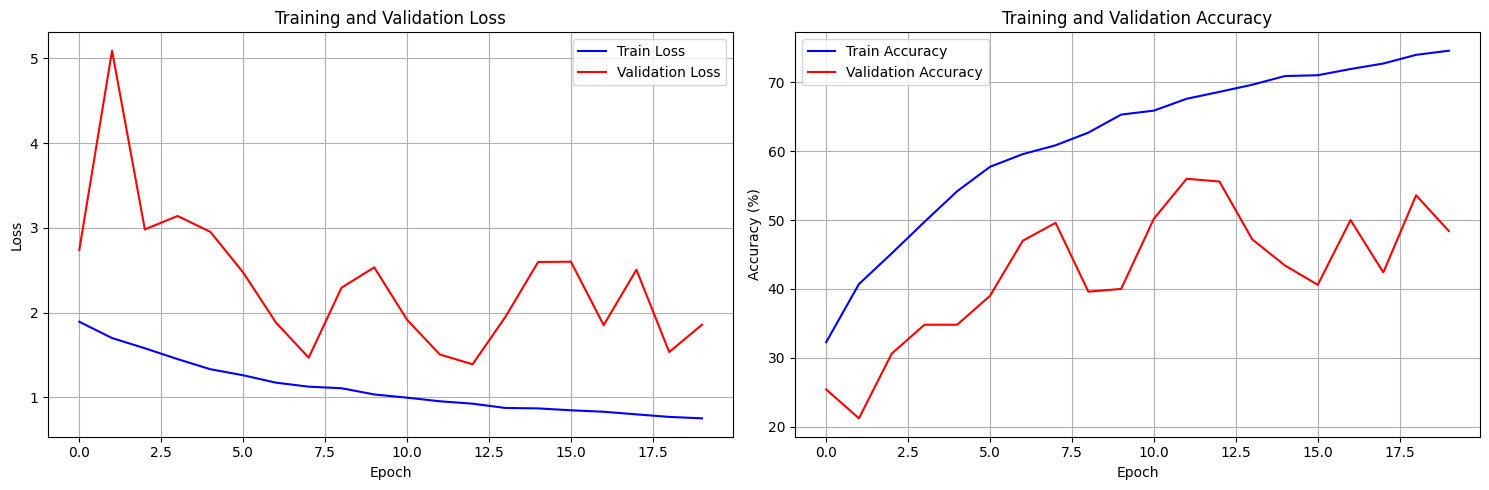

In [63]:
plot_training_history(history)

Вариант C: ELU

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNet_33C(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Первый слой: свертка 3x3 с шагом 1, padding=1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ELU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Пулинг с ядром 3x3 и шагом 2

        # Слои BasicBlock
        self.basic_block_1_0 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)  

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)  

        # Финальные слои
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc = nn.Linear(256, num_classes)  

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  
        x = self.maxpool(x)  

        # Пропускаем через слои BasicBlock
        x = self.basic_block_1_0(x)

        x = self.basic_block_2_0(x)

        x = self.basic_block_3_0(x)

        # Применяем адаптивный пулинг
        x = self.avgpool(x)

        # Преобразуем в один вектор
        x = torch.flatten(x, 1)

        # Прогоняем через полносвязный слой
        x = self.fc(x)

        return x


# Пример использования модели
model = SimpleResNet_33C(num_classes=10)  # 10 классов
test_input = torch.randn(1, 3, 224, 224)  # Пример входа с размерами (1, 3, 224, 224)

output = model(test_input)
print(output.shape)  # Проверим размерность вывода

# Выводим статистику о параметрах модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


torch.Size([1, 10])
Всего параметров: 1,228,874
Обучаемых параметров: 1,228,874


In [64]:
model = SimpleResNet_33C(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)



Обучение на 20 эпох...
 Эпоха 1/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.9263, Train Acc: 30.72%
 Val Loss: 5.8590, Val Acc: 17.40%
 Сохранена лучшая модель с точностью 17.40%
 Эпоха 2/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.7032, Train Acc: 39.98%
 Val Loss: 3.4709, Val Acc: 28.40%
 Сохранена лучшая модель с точностью 28.40%
 Эпоха 3/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.5578, Train Acc: 45.56%
 Val Loss: 2.5841, Val Acc: 31.80%
 Сохранена лучшая модель с точностью 31.80%
 Эпоха 4/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.4565, Train Acc: 50.54%
 Val Loss: 2.7880, Val Acc: 30.20%
 Эпоха 5/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.3331, Train Acc: 54.80%
 Val Loss: 4.3586, Val Acc: 26.40%
 Эпоха 6/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.2446, Train Acc: 57.48%
 Val Loss: 2.1515, Val Acc: 41.60%
 Сохранена лучшая модель с точностью 41.60%
 Эпоха 7/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1924, Train Acc: 59.14%
 Val Loss: 2.4513, Val Acc: 35.00%
 Эпоха 8/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1465, Train Acc: 61.38%
 Val Loss: 1.7216, Val Acc: 46.20%
 Сохранена лучшая модель с точностью 46.20%
 Эпоха 9/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.0668, Train Acc: 64.18%
 Val Loss: 2.4638, Val Acc: 41.60%
 Эпоха 10/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.0459, Train Acc: 64.62%
 Val Loss: 2.0437, Val Acc: 42.80%
 Эпоха 11/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9979, Train Acc: 66.30%
 Val Loss: 1.6385, Val Acc: 48.80%
 Сохранена лучшая модель с точностью 48.80%
 Эпоха 12/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9839, Train Acc: 67.22%
 Val Loss: 1.2406, Val Acc: 58.40%
 Сохранена лучшая модель с точностью 58.40%
 Эпоха 13/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9336, Train Acc: 68.32%
 Val Loss: 1.4058, Val Acc: 55.80%
 Эпоха 14/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9212, Train Acc: 69.30%
 Val Loss: 2.5875, Val Acc: 42.00%
 Эпоха 15/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8911, Train Acc: 69.62%
 Val Loss: 1.7891, Val Acc: 46.80%
 Эпоха 16/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8595, Train Acc: 70.48%
 Val Loss: 2.9145, Val Acc: 40.00%
 Эпоха 17/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8282, Train Acc: 71.98%
 Val Loss: 1.2327, Val Acc: 58.60%
 Сохранена лучшая модель с точностью 58.60%
 Эпоха 18/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8013, Train Acc: 73.00%
 Val Loss: 1.9007, Val Acc: 50.20%
 Эпоха 19/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.7803, Train Acc: 74.08%
 Val Loss: 1.3208, Val Acc: 59.40%
 Сохранена лучшая модель с точностью 59.40%
 Эпоха 20/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]

 Train Loss: 0.7496, Train Acc: 74.64%
 Val Loss: 1.4662, Val Acc: 51.20%


In [65]:
print(best_acc_val)

59.4


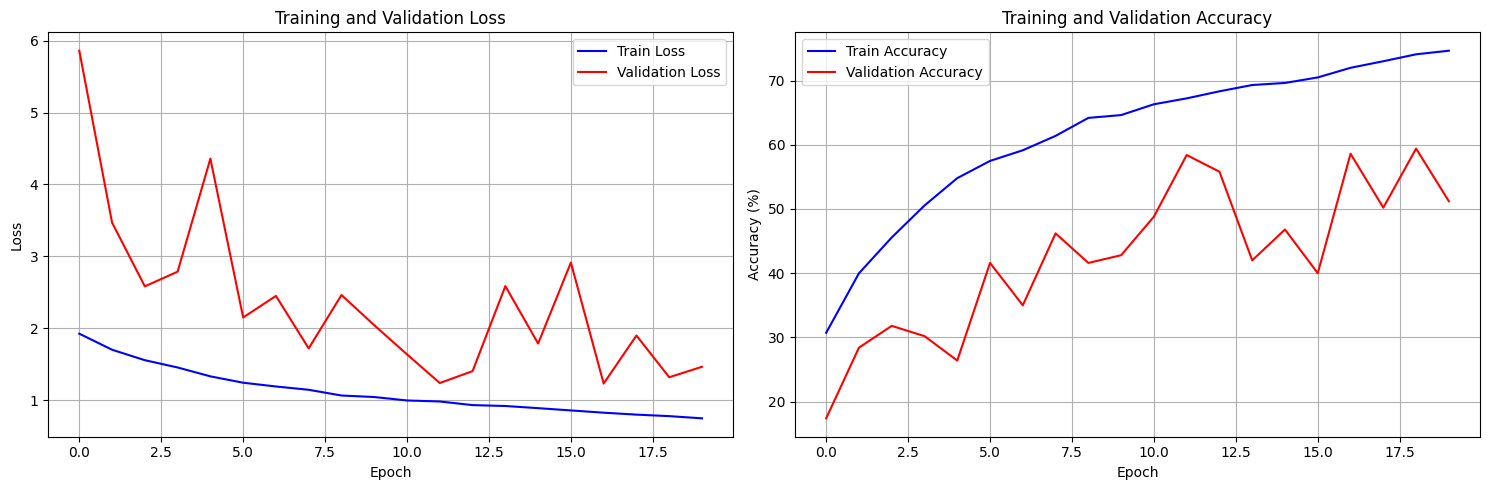

In [66]:
plot_training_history(history)

Вариант D: GELU

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNet_33D(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Первый слой: свертка 3x3 с шагом 1, padding=1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.GELU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Пулинг с ядром 3x3 и шагом 2

        # Слои BasicBlock
        self.basic_block_1_0 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)  

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)  

        # Финальные слои
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc = nn.Linear(256, num_classes)  

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  
        x = self.maxpool(x)  

        # Пропускаем через слои BasicBlock
        x = self.basic_block_1_0(x)

        x = self.basic_block_2_0(x)

        x = self.basic_block_3_0(x)

        # Применяем адаптивный пулинг
        x = self.avgpool(x)

        # Преобразуем в один вектор
        x = torch.flatten(x, 1)

        # Прогоняем через полносвязный слой
        x = self.fc(x)

        return x


# Пример использования модели
model = SimpleResNet_33D(num_classes=10)  # 10 классов
test_input = torch.randn(1, 3, 224, 224)  # Пример входа с размерами (1, 3, 224, 224)

output = model(test_input)
print(output.shape)  # Проверим размерность вывода

# Выводим статистику о параметрах модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


torch.Size([1, 10])
Всего параметров: 1,228,874
Обучаемых параметров: 1,228,874


In [70]:
model = SimpleResNet_33D(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)



Обучение на 20 эпох...
 Эпоха 1/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.9272, Train Acc: 30.76%
 Val Loss: 2.7429, Val Acc: 25.40%
 Сохранена лучшая модель с точностью 25.40%
 Эпоха 2/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.7205, Train Acc: 38.64%
 Val Loss: 2.0634, Val Acc: 36.20%
 Сохранена лучшая модель с точностью 36.20%
 Эпоха 3/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.5632, Train Acc: 45.40%
 Val Loss: 1.9271, Val Acc: 39.60%
 Сохранена лучшая модель с точностью 39.60%
 Эпоха 4/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.4654, Train Acc: 50.50%
 Val Loss: 2.5422, Val Acc: 36.60%
 Эпоха 5/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.3875, Train Acc: 53.52%
 Val Loss: 1.9850, Val Acc: 39.60%
 Эпоха 6/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.2648, Train Acc: 56.76%
 Val Loss: 3.2424, Val Acc: 33.20%
 Эпоха 7/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.2306, Train Acc: 58.78%
 Val Loss: 3.8976, Val Acc: 28.00%
 Эпоха 8/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1905, Train Acc: 59.06%
 Val Loss: 2.2356, Val Acc: 38.40%
 Эпоха 9/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1247, Train Acc: 61.28%
 Val Loss: 2.1400, Val Acc: 37.80%
 Эпоха 10/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.0699, Train Acc: 64.50%
 Val Loss: 3.1179, Val Acc: 31.40%
 Эпоха 11/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.0480, Train Acc: 64.52%
 Val Loss: 1.8852, Val Acc: 46.40%
 Сохранена лучшая модель с точностью 46.40%
 Эпоха 12/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9800, Train Acc: 67.46%
 Val Loss: 2.5329, Val Acc: 42.00%
 Эпоха 13/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9478, Train Acc: 68.40%
 Val Loss: 6.2679, Val Acc: 30.60%
 Эпоха 14/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9312, Train Acc: 69.08%
 Val Loss: 1.8612, Val Acc: 44.20%
 Эпоха 15/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8837, Train Acc: 69.32%
 Val Loss: 2.4090, Val Acc: 41.20%
 Эпоха 16/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8814, Train Acc: 69.98%
 Val Loss: 1.7476, Val Acc: 50.40%
 Сохранена лучшая модель с точностью 50.40%
 Эпоха 17/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8346, Train Acc: 72.34%
 Val Loss: 1.8733, Val Acc: 46.40%
 Эпоха 18/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8424, Train Acc: 70.98%
 Val Loss: 2.0442, Val Acc: 49.80%
 Эпоха 19/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.7920, Train Acc: 73.16%
 Val Loss: 1.8053, Val Acc: 48.20%
 Эпоха 20/20


Validation:   0%|          | 0/8 [00:01<?, ?it/s]

 Train Loss: 0.7827, Train Acc: 73.16%
 Val Loss: 2.1583, Val Acc: 46.20%


In [73]:
print(best_acc_val)

50.4


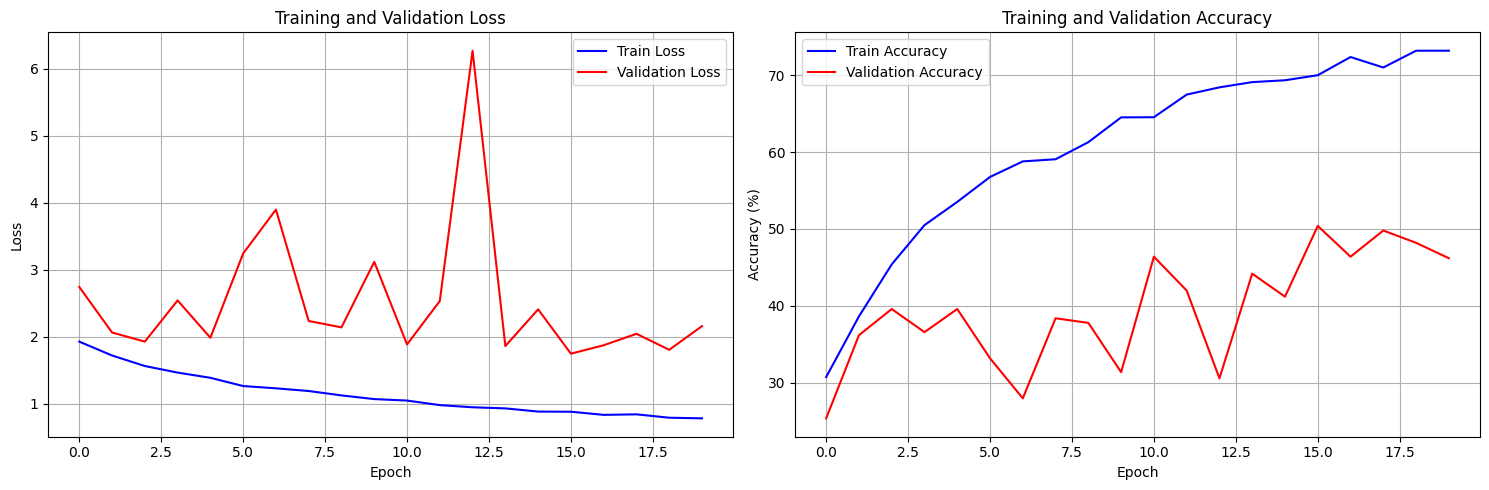

In [74]:
plot_training_history(history)

In [75]:
results = [
    {"Модель": "Relu", "Точность": '55.6', "Скорость сходимости": '16'},
    {"Модель": "LeakyReLU", "Точность": '56', "Скорость сходимости": '13'},
    {"Модель": "ELU", "Точность": '59.4', "Скорость сходимости": '19'},
    {"Модель": "GELU", "Точность": '50.4', "Скорость сходимости": '16'},

]

df = pd.DataFrame(results)
df

,Модель,Точность,Скорость сходимости
0,Relu,55.6,16
1,LeakyReLU,56,13
2,ELU,59.4,19
3,GELU,50.4,16


Лучшая скорость сходимости у LeakyReLU, но точность лучше у ELU. ELU и будем использовать далее


### 4.1: Создание финальной модели

In [76]:
model = SimpleResNet_33C(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=30
)



Обучение на 30 эпох...
 Эпоха 1/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.9146, Train Acc: 31.14%
 Val Loss: 2.6721, Val Acc: 28.40%
 Сохранена лучшая модель с точностью 28.40%
 Эпоха 2/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.7081, Train Acc: 39.70%
 Val Loss: 3.8027, Val Acc: 26.40%
 Эпоха 3/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.5747, Train Acc: 45.94%
 Val Loss: 3.8347, Val Acc: 26.60%
 Эпоха 4/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.4074, Train Acc: 52.24%
 Val Loss: 3.0108, Val Acc: 34.40%
 Сохранена лучшая модель с точностью 34.40%
 Эпоха 5/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.3394, Train Acc: 53.66%
 Val Loss: 2.8283, Val Acc: 30.60%
 Эпоха 6/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.2561, Train Acc: 57.48%
 Val Loss: 2.0168, Val Acc: 41.20%
 Сохранена лучшая модель с точностью 41.20%
 Эпоха 7/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1986, Train Acc: 58.96%
 Val Loss: 1.7407, Val Acc: 48.80%
 Сохранена лучшая модель с точностью 48.80%
 Эпоха 8/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.1089, Train Acc: 63.36%
 Val Loss: 2.2659, Val Acc: 38.00%
 Эпоха 9/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.0765, Train Acc: 63.40%
 Val Loss: 2.6721, Val Acc: 40.00%
 Эпоха 10/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 1.0174, Train Acc: 66.48%
 Val Loss: 1.9745, Val Acc: 45.40%
 Эпоха 11/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9851, Train Acc: 66.34%
 Val Loss: 1.8069, Val Acc: 51.40%
 Сохранена лучшая модель с точностью 51.40%
 Эпоха 12/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9511, Train Acc: 68.38%
 Val Loss: 1.5598, Val Acc: 54.60%
 Сохранена лучшая модель с точностью 54.60%
 Эпоха 13/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9375, Train Acc: 69.28%
 Val Loss: 2.0300, Val Acc: 46.00%
 Эпоха 14/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.9306, Train Acc: 68.64%
 Val Loss: 1.3718, Val Acc: 57.40%
 Сохранена лучшая модель с точностью 57.40%
 Эпоха 15/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8415, Train Acc: 71.86%
 Val Loss: 2.2477, Val Acc: 45.40%
 Эпоха 16/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8616, Train Acc: 71.18%
 Val Loss: 1.8578, Val Acc: 45.00%
 Эпоха 17/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8156, Train Acc: 72.70%
 Val Loss: 1.6597, Val Acc: 51.80%
 Эпоха 18/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.7929, Train Acc: 73.86%
 Val Loss: 1.7804, Val Acc: 51.20%
 Эпоха 19/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.8104, Train Acc: 71.96%
 Val Loss: 1.7995, Val Acc: 51.40%
 Эпоха 20/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.7641, Train Acc: 74.44%
 Val Loss: 1.4506, Val Acc: 55.80%
 Эпоха 21/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.7617, Train Acc: 75.08%
 Val Loss: 1.4864, Val Acc: 55.60%
 Эпоха 22/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.7403, Train Acc: 75.20%
 Val Loss: 1.5637, Val Acc: 54.80%
 Эпоха 23/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.7057, Train Acc: 76.60%
 Val Loss: 1.5209, Val Acc: 59.40%
 Сохранена лучшая модель с точностью 59.40%
 Эпоха 24/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.7020, Train Acc: 75.70%
 Val Loss: 1.3202, Val Acc: 60.80%
 Сохранена лучшая модель с точностью 60.80%
 Эпоха 25/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.6973, Train Acc: 76.02%
 Val Loss: 2.0678, Val Acc: 49.00%
 Эпоха 26/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.6560, Train Acc: 78.12%
 Val Loss: 1.4855, Val Acc: 58.60%
 Эпоха 27/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.6215, Train Acc: 78.80%
 Val Loss: 1.2472, Val Acc: 61.40%
 Сохранена лучшая модель с точностью 61.40%
 Эпоха 28/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.6070, Train Acc: 79.54%
 Val Loss: 1.5852, Val Acc: 53.40%
 Эпоха 29/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]


 Train Loss: 0.6285, Train Acc: 78.58%
 Val Loss: 1.4148, Val Acc: 59.00%
 Эпоха 30/30


Validation:   0%|          | 0/8 [00:01<?, ?it/s]

 Train Loss: 0.5853, Train Acc: 79.90%
 Val Loss: 1.2513, Val Acc: 62.00%
 Сохранена лучшая модель с точностью 62.00%


In [77]:
print(best_acc_val)

62.0


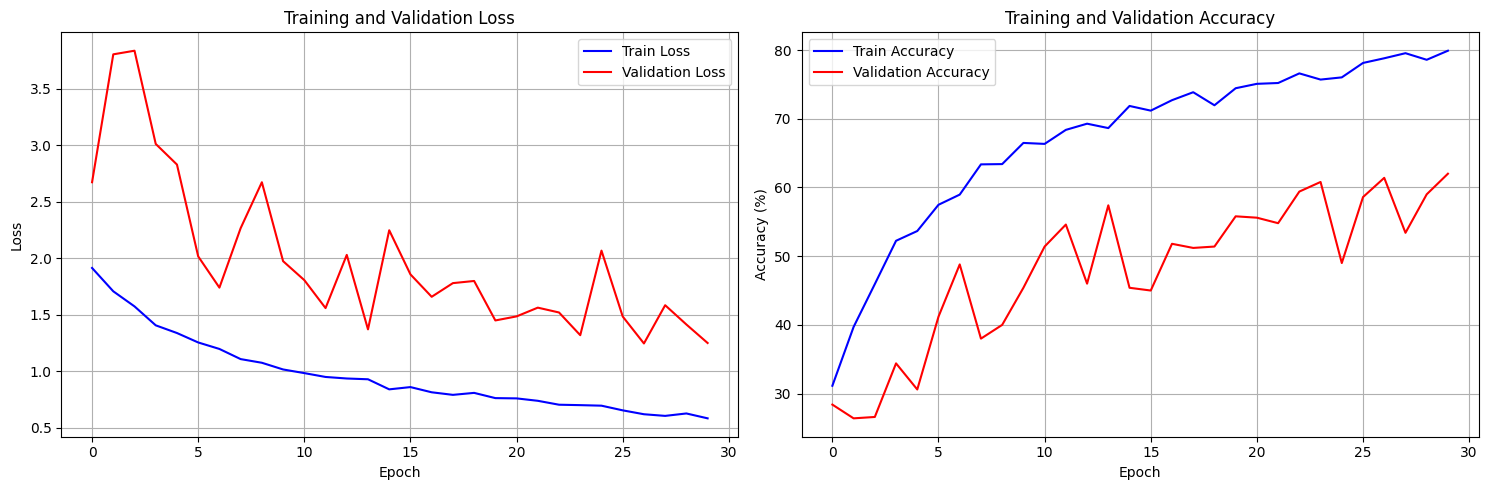

In [78]:
plot_training_history(history)

При увеличении кол-ва эпох повысилась точность. Скорость сходимости - 30

In [83]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def test(model, test_loader, classes, device):
    model.to(device)
    model.eval()

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            
            all_targets.append(target.cpu().numpy())
            all_predictions.append(predicted.cpu().numpy())

    targets = np.concatenate(all_targets)
    predictions = np.concatenate(all_predictions)

    acc = accuracy_score(targets, predictions)
    cm = confusion_matrix(targets, predictions)
    
    report_str = classification_report(
        targets, predictions,
        target_names=classes,
        digits=4,
        zero_division=0
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=classes,
        yticklabels=classes,
        cbar_kws={'shrink': 0.8}
    )
    plt.title(f'Confusion Matrix (Accuracy: {acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    print(f"\n✅ Test Accuracy: {100 * acc:.2f}%\n")
    print("📊 Classification Report:")
    print(report_str)

    return {
        'accuracy': acc,
        'report': report_str,
        'confusion_matrix': cm,
        'predictions': predictions,
        'targets': targets
    }

def load_tiny_imagenet_labels(words_path="data/tiny-imagenet-200/words.txt"):
    labels = {}
    with open(words_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                wnid = parts[0]
                desc = parts[1]
                labels[wnid] = desc
    return labels

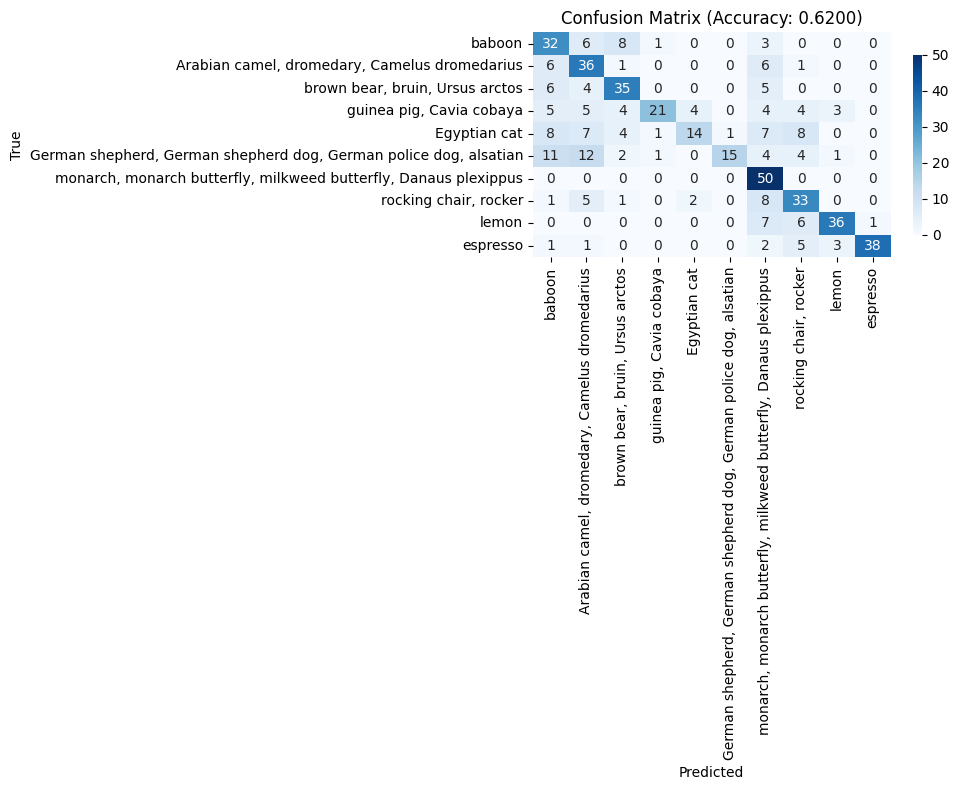


✅ Test Accuracy: 62.00%

📊 Classification Report:
                                                                   precision    recall  f1-score   support

                                                           baboon     0.4571    0.6400    0.5333        50
                    Arabian camel, dromedary, Camelus dromedarius     0.4737    0.7200    0.5714        50
                                  brown bear, bruin, Ursus arctos     0.6364    0.7000    0.6667        50
                                         guinea pig, Cavia cobaya     0.8750    0.4200    0.5676        50
                                                     Egyptian cat     0.7000    0.2800    0.4000        50
German shepherd, German shepherd dog, German police dog, alsatian     0.9375    0.3000    0.4545        50
 monarch, monarch butterfly, milkweed butterfly, Danaus plexippus     0.5208    1.0000    0.6849        50
                                            rocking chair, rocker     0.5410    0.6600    0.

In [84]:
model_final_test = SimpleResNet_33C(10)

checkpoint = torch.load('best_model.pth', map_location=device)
model_final_test.load_state_dict(checkpoint)

calsses_names = load_tiny_imagenet_labels()
calsses = [calsses_names[val_dataset.class_names[i]] for i in selected_classes] 

results = test(model_final_test, val_loader, calsses, device)

Модель неплохо распознает Эспрессо, но есть проблемы с египетскими котами

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

def visualize_predictions(model, test_dataset, device, class_names=None, n_samples=10, seed=42):
    """
    Визуализирует n_samples случайных примеров из test_dataset с истинными и предсказанными классами.
    
    Args:
        model: обученная модель
        test_dataset: Dataset (например, val_subset_dataset)
        device: 'cpu' или 'cuda'
        class_names: список имён классов (длиной = num_classes), например: ['goldfish', 'tabby', ...]
        n_samples: сколько примеров показать
        seed: для воспроизводимости
    """
    model.eval()
    
    rng = np.random.default_rng(seed)
    indices = rng.choice(len(test_dataset), size=n_samples, replace=False)
    
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img_tensor, true_label = test_dataset[idx] 
            img_tensor = img_tensor.unsqueeze(0).to(device)  # [1, C, H, W]
            
            output = model(img_tensor)
            _, pred_label = output.max(1)
            pred_label = pred_label.item()
            true_label = true_label.item() if isinstance(true_label, torch.Tensor) else true_label
            
            img_vis = inv_normalize(img_tensor.squeeze(0).cpu())
            img_vis = torch.clamp(img_vis, 0, 1)  # значения в [0,1]
            img_np = img_vis.permute(1, 2, 0).numpy()
            
            true_name = class_names[true_label] if class_names else f"Class {true_label}"
            pred_name = class_names[pred_label] if class_names else f"Class {pred_label}"
            color = "green" if true_label == pred_label else "red"
            
            axes[i].imshow(img_np)
            axes[i].set_title(f"True: {true_name}\nPred: {pred_name}", 
                              color=color, fontsize=10)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Test Set Predictions (Green = Correct, Red = Wrong)", y=1.02, fontsize=14)
    plt.show()

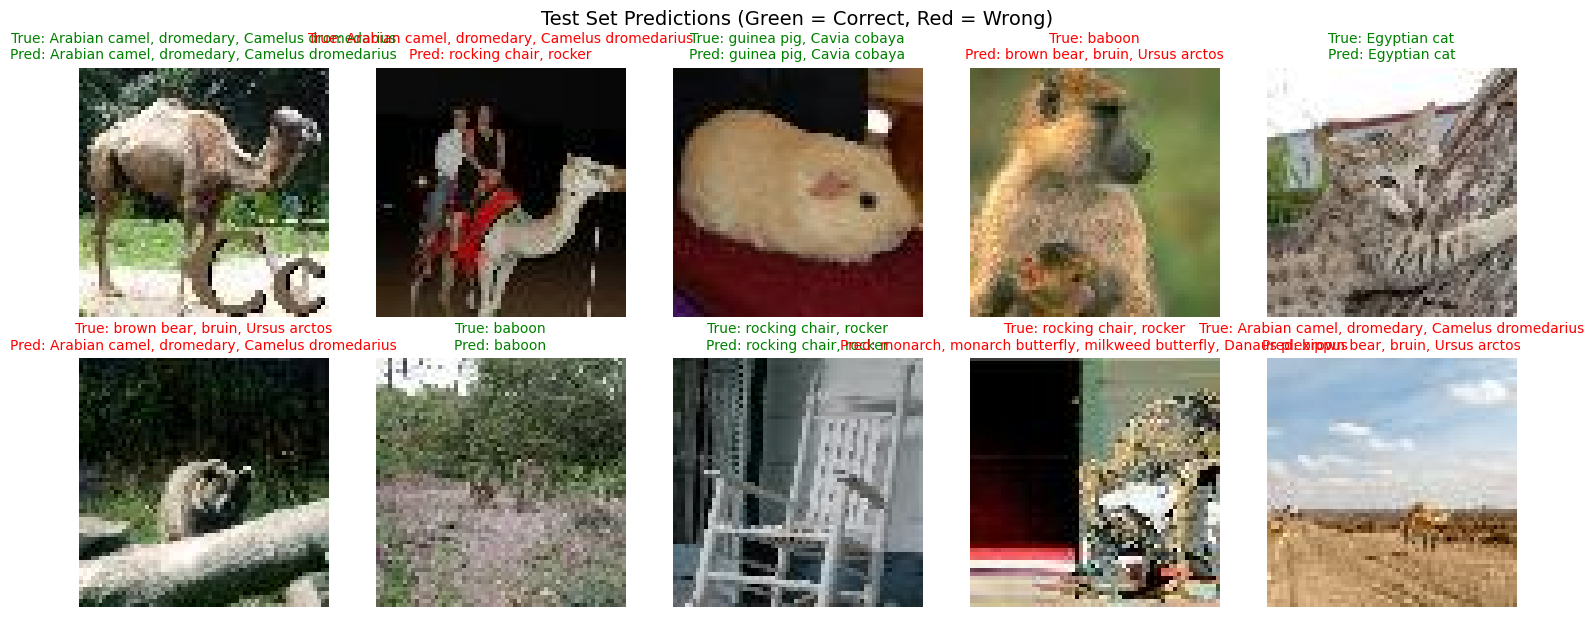

In [86]:
visualize_predictions(model, val_subset_dataset, device, class_names=calsses)

In [88]:
results = [
    {"Этап": "Baseline", "Конфигурация": "Базовая модель", "Параметры": '2,779,850', "Val Accuracy": '59.8', "Train Accuracy": '74.4'},
    {"Этап": "3.1-A", "Конфигурация": "32→64→128→256", "Параметры": '2,762,730', "Val Accuracy":  '59.2', "Train Accuracy": '74.6'},
    {"Этап": "3.1-B", "Конфигурация": "64→128→256", "Параметры": '2,779,850', "Val Accuracy": '59.8', "Train Accuracy": '74.4'},
    {"Этап": "3.2-A", "Конфигурация": "[1,1,1] блоков", "Параметры": '1,228,874', "Val Accuracy": '55.6', "Train Accuracy": '74.6'},
    {"Этап": "3.2-B", "Конфигурация": "[2,2,2] блоков", "Параметры": '2,779,850', "Val Accuracy": '54.8', "Train Accuracy": '74.7'},
    {"Этап": "3.2-C", "Конфигурация": "[3,3,3] блоков", "Параметры": '4,330,826', "Val Accuracy": '62.2', "Train Accuracy": '71.2'},
    {"Этап": "3.3-A", "Конфигурация": "ReLU", "Параметры": '1,228,874', "Val Accuracy": '55.6', "Train Accuracy": '74.6'},
    {"Этап": "3.3-B", "Конфигурация": "LeakyReLU", "Параметры": '1,228,874', "Val Accuracy": '56', "Train Accuracy": '74.6'},
    {"Этап": "3.3-C", "Конфигурация": "ELU", "Параметры": '1,228,874', "Val Accuracy": '59.4', "Train Accuracy": '74.6'},
    {"Этап": "3.3-D", "Конфигурация": "GELU ", "Параметры": '1,228,874', "Val Accuracy": '50.4', "Train Accuracy": '73.2'},
    {"Этап": "Final", "Конфигурация": "Лучшая конфигурация", "Параметры": '1,228,874', "Val Accuracy": '62', "Train Accuracy": '79.9'},
]

df = pd.DataFrame(results)
df

,Этап,Конфигурация,Параметры,Val Accuracy,Train Accuracy
0,Baseline,Базовая модель,"2,779,850",59.8,74.4
1,3.1-A,32→64→128→256,"2,762,730",59.2,74.6
2,3.1-B,64→128→256,"2,779,850",59.8,74.4
3,3.2-A,"[1,1,1] блоков","1,228,874",55.6,74.6
4,3.2-B,"[2,2,2] блоков","2,779,850",54.8,74.7
5,3.2-C,"[3,3,3] блоков","4,330,826",62.2,71.2
6,3.3-A,ReLU,"1,228,874",55.6,74.6
7,3.3-B,LeakyReLU,"1,228,874",56,74.6
8,3.3-C,ELU,"1,228,874",59.4,74.6
9,3.3-D,GELU,"1,228,874",50.4,73.2
